# Neural Message Passing

To discover a proficient variant of supervised learning methodologies in molecular applications and to apply it to chemical prediction benchmarks, Gilmer et al. (2017) have proposed a reformulation of prevailing neural network models that are invariant to molecular symmetries within a framework termed as Message Passing Neural Networks (MPNNs).

MPNNs' forward pass comprises a message passing phase and a readout phase. The message passing phase is executed for a specific number of time steps $T$. Given an undirected graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ with a set of node features $\textbf{X} \in \mathbb{R}^{d \times |\mathcal{V}|}$ and a set of edge features $\textbf{E} \in \mathbb{R}^{d \times |\mathcal{V}| \times |\mathcal{V'}|}$, the authors define the message at the $t^{\text{th}}$ message passing phase as follows:

\begin{align*}
    m_u^{(t)} &= \sum_{v \in \mathcal{N}(u)} \textbf{M}^{(t-1)} \left( h^{(t-1)}_u, h^{(t-1)}_v, \textbf{E}_{uv} \right) \\
    h^{(t)}_u &= \textbf{U}_t \left( h^{(t-1)}_u, m_u^{(t-1)} \right) \\
\end{align*}

where

- for each node $u \in \mathcal{V}$, $v \in \mathcal{N}(u)$ and $\mathcal{N}(u)$ is the set of neighbourhood nodes of $u$
- $\textbf{M}^{(t)}$ is the message function at $t^{\text{th}}$ phase
- $h^{(t)}_v$ is the hidden states
- $\textbf{U}^{(t)}$ is the vertex update function
- Here, $\textbf{M}$, $\textbf{U}$, $\textbf{R}$ are all learned differentiable functions.

Given some readout function $\textbf{R}$, the readout phase computes a feature vector for $\mathcal{G}$ is given by

$$
\hat{y} = \textbf{R} \left( \left\{ h_u^{(T)} | u \in \mathcal{\mathcal{V}} \right\} \right)
$$

In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
from data.dataset import Dataset
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.DGLModel import DGLModel
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import torch

In [3]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [4]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [5]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "node_out_feats": tune.choice([32, 64, 128, 256]),
    "edge_hidden_feats": tune.choice([32, 64, 128, 256]),
    "num_step_message_passing": tune.choice([4, 6, 8]),
    "num_step_set2set": tune.choice([4, 6, 8]),
    "num_layer_set2set": tune.choice([3, 4, 5, 6]),
    "lr": tune.choice([0.1, 0.01, 0.001]),
    "weight_decay": tune.uniform(0, 1),
    "epoch": tune.choice([100, 150, 200, 250, 300]),
}

In [6]:
from model.dgl.MPNN import MPNN
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    try:
        model = MPNN(
            task_type="regression",
            # MPNN Configuration
            n_tasks=1,
            node_in_feats=featurizer.get_node_feat_size(),
            edge_in_feats=featurizer.get_edge_feat_size(),
            node_out_feats=config["node_out_feats"],
            edge_hidden_feats=config["edge_hidden_feats"],
            num_step_message_passing=config["num_step_message_passing"],
            num_step_set2set=config["num_step_set2set"],
            num_layer_set2set=config["num_layer_set2set"],
            # Abstract DGL Configuration
            lr=config["lr"],
            y_name="LogS exp (mol/L)",
            weight_decay=config["weight_decay"],
            batch_size=128,
            verbose=False
        )
        scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
        tune.report(rmse=np.average(scores["rmse"]))
    except Exception as e:
        print(f"{e}. Config: {config}\nSkip this trail")

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=30,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-16 11:48:40,066	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_79e50_00000,2023-03-16_12-02-59,False,,28116107de9f44f98872031963010dce,64-4090-13700K,1,127.0.0.1,40092,3.20147,850.593,850.593,850.593,1678968179,0,,1,79e50_00000,0.00599098


(trainable_func pid=40092) [13:22:17] C:\Users\Administrator\dgl-0.5\src\runtime\cuda\cuda_device_api.cc:116: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading: CUDA: out of memory. Config: {'node_out_feats': 128, 'edge_hidden_feats': 256, 'num_step_message_passing': 8, 'num_step_set2set': 4, 'num_layer_set2set': 6, 'lr': 0.01, 'weight_decay': 0.20930316921777226, 'epoch': 300}
(trainable_func pid=40092) Skip this trail
Trial trainable_func_79e50_00003 completed. Last result: 
(trainable_func pid=40092) CUDA out of memory. Tried to allocate 27.13 GiB (GPU 0; 23.99 GiB total capacity; 280.63 MiB already allocated; 20.42 GiB free; 950.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF. Config: {'node_out_feats': 256, 'edge_hidden_feats': 128, 'num_step_message_passing': 6, 'num_step_set2set': 4, 'num_layer_set2set': 4, 'lr': 

2023-03-16 17:04:28,962	INFO tune.py:798 -- Total run time: 18942.48 seconds (18942.35 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'node_out_feats': 32,
 'edge_hidden_feats': 256,
 'num_step_message_passing': 4,
 'num_step_set2set': 8,
 'num_layer_set2set': 5,
 'lr': 0.1,
 'weight_decay': 0.014689703645914265,
 'epoch': 200}

In [5]:
from model.dgl.MPNN import MPNN

MODEL = MPNN(
    task_type="regression",
    # MPNN Configuration
    n_tasks=1,
    node_in_feats=featurizer.get_node_feat_size(),
    edge_in_feats=featurizer.get_edge_feat_size(),
    node_out_feats=32,
    edge_hidden_feats=256,
    num_step_message_passing=4,
    num_step_set2set=8,
    num_layer_set2set=5,
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0.014689703645914265,
    batch_size=1024
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=300)

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


100%|██████████| 300/300 [04:50<00:00,  1.03it/s, loss: 4.285 rmse: 1.181]


<AxesSubplot: >

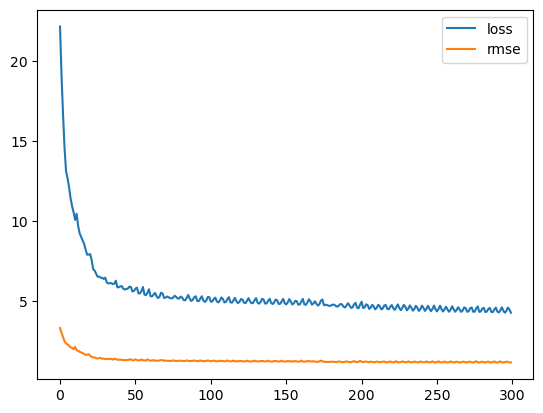

In [6]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [7]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=300,
    extra_eval_set=TST1,
    cv=3,
    verbose=True
)

[CV 2]: 100%|██████████| 300/300 [04:16<00:00,  1.17it/s, loss: 3.715, val_rmse: 1.028]


In [8]:
np.std(result["rmse"]), np.mean(result["rmse"])

(0.3114719, 1.4641825)

In [9]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 1.259664366458153
TST2 : RMSE 1.8114016249250275


In [5]:
SPACE = {
    "node_out_feats": tune.uniform(24, 64),
    "edge_hidden_feats": tune.uniform(32, 64),
    "num_step_message_passing": tune.uniform(2, 6),
    "num_step_set2set": tune.uniform(6, 12),
    "num_layer_set2set": tune.uniform(3, 6),
    "weight_decay": tune.uniform(0, 0.3),
}

In [9]:
from model.dgl.MPNN import MPNN
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    try:
        model = MPNN(
            task_type="regression",
            # MPNN Configuration
            n_tasks=1,
            node_in_feats=featurizer.get_node_feat_size(),
            edge_in_feats=featurizer.get_edge_feat_size(),
            node_out_feats=int(config["node_out_feats"]),
            edge_hidden_feats=int(config["edge_hidden_feats"]),
            num_step_message_passing=int(config["num_step_message_passing"]),
            num_step_set2set=int(config["num_step_set2set"]),
            num_layer_set2set=int(config["num_layer_set2set"]),
            # Abstract DGL Configuration
            lr=0.001,
            y_name="LogS exp (mol/L)",
            weight_decay=config["weight_decay"],
            batch_size=128,
            verbose=False
        )
        scores = model.fit(trn, val=val, epochs=300, verbose=False)
        tune.report(rmse=np.average(scores["rmse"]))
    except Exception as e:
        print(f"{e}. Config: {config}\nSkip this trail")

In [10]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=30,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_f12f3_00000,2023-03-17_12-30-14,False,,b1bb278db0cf42a7b4ddf98653bad42a,64-4090-13700K,1,127.0.0.1,884,2.00936,1079.9,1079.9,1079.9,1679056214,0,,1,f12f3_00000,0.00300837


2023-03-17 13:42:55,143	WARNING util.py:244 -- The `on_step_begin` operation took 1.159 s, which may be a performance bottleneck.
2023-03-17 18:30:51,845	INFO tune.py:798 -- Total run time: 22719.57 seconds (22719.56 seconds for the tuning loop).


In [11]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'node_out_feats': 62.83765760311187,
 'edge_hidden_feats': 56.225712558923604,
 'num_step_message_passing': 2.1319310830902287,
 'num_step_set2set': 7.775247557115647,
 'num_layer_set2set': 4.912873003435657,
 'weight_decay': 0.008810928673332262}

In [11]:
from model.dgl.MPNN import MPNN

num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = MPNN(
        task_type="regression",
        # MPNN Configuration
        n_tasks=1,
        node_in_feats=featurizer.get_node_feat_size(),
        edge_in_feats=featurizer.get_edge_feat_size(),
        node_out_feats=63,
        edge_hidden_feats=56,
        num_step_message_passing=2,
        num_step_set2set=8,
        num_layer_set2set=5,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.008810928673332262,
        batch_size=1024
    )
    model.fit(trn, val=val, epochs=1000, min_epoch=800, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 85%|████████▌ | 852/1000 [13:23<02:19,  1.06it/s, loss: 4.672 rmse: 1.215]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 83%|████████▎ | 829/1000 [13:12<02:43,  1.05it/s, loss: 3.752 rmse: 1.612]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 85%|████████▍ | 846/1000 [13:25<02:26,  1.05it/s, loss: 3.945 rmse: 1.535]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 86%|████████▌ | 855/1000 [13:42<02:19,  1.04it/s, loss: 4.027 rmse: 0.931]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 83%|████████▎ | 830/1000 [13:10<02:41,  1.05it/s, loss: 3.839 rmse: 1.181]


In [12]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [13]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 1.2068815427229005
TST2 : RMSE 1.869764224540073


In [14]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.09104140287532114
TST2 : R^2 0.23783561643423312


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (MPNN)\nRMSE: 1.870, $R^2$: 0.238')

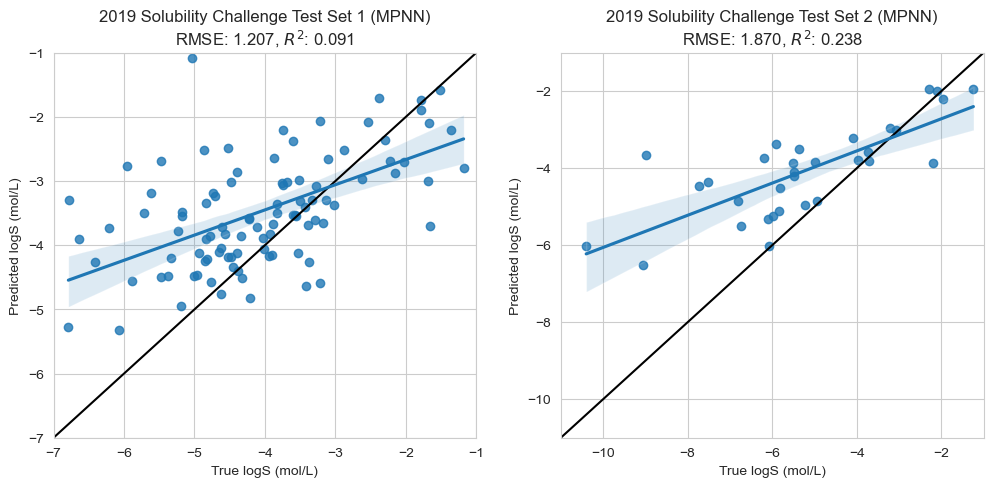

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "MPNN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")